In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.animation as animation
import time as TIME
import math
import re
import random
from pymoo.indicators.hv import HV
from multiprocessing import Pool
import multiprocessing
import scipy.sparse as sp

In [2]:
# 10部件                         1 2 3 4 5 6 7 8 9 10
prior_constrain_p10 = np.array([[0,1,1,1,1,0,0,0,0,0], # 1
                                [0,0,0,0,0,1,0,0,0,0], # 2
                                [0,0,0,0,0,0,0,0,0,0], # 3
                                [0,0,0,0,0,0,1,0,0,0], # 4
                                [0,0,0,0,0,0,0,0,0,0], # 5
                                [0,0,0,0,0,0,0,1,0,0], # 6
                                [0,0,0,0,0,0,0,0,1,0], # 7
                                [0,0,0,0,0,0,0,0,0,0], # 8
                                [0,0,0,0,0,0,0,0,0,1], # 9
                                [0,0,0,0,0,0,0,0,0,0]])# 10
num_of_part_p10 = 10
CT_p10 = 26
time_p10 = np.array([3, 8, 6, 10, 9, 6, 7, 7, 10, 7])
danger_p10 = np.array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])
need_p10 = np.array([0, 500, 0, 0, 0, 750, 295, 0, 360, 0])
disassembly_side_p10 = np.array([1, -1, 1, 1, 1, 1, 0, 1, -1, 0]) # 1左边，-1右边，0两边都可以
relate_p10 = np.zeros(shape=(num_of_part_p10, num_of_part_p10))
revenue_p10 = np.array([20.03, 30.12, 30.25, 20.52, 30.65, 20.51, 10.75, 50.80, 30.46, 30.60])
c_p10 = 0.35

In [3]:
class get_candid:
    def __init__(self, prior_constrain, disassembly_side):
        self.prior_constrain = copy.deepcopy(prior_constrain)
        self.disassembly_side = disassembly_side
        
    def get_can_do_task(self, did_tasks):
        did_tasks_with0_encoding = [abs(ele)-1 for ele in did_tasks]
        self.prior_constrain[did_tasks_with0_encoding, :] = 0
        can_do_tasks = np.argwhere(np.sum(self.prior_constrain, axis=0)==0).reshape(-1).tolist()
        for did_task in did_tasks_with0_encoding:
            can_do_tasks.remove(did_task)
        can_do_tasks = (np.array(can_do_tasks) + 1).tolist()
        can_do_tasks_duplic = copy.deepcopy(can_do_tasks)
        for ele in can_do_tasks_duplic:
            if self.disassembly_side[ele-1] == -1:
                can_do_tasks.remove(ele)
                can_do_tasks.append(-1*ele)
            elif self.disassembly_side[ele-1] == 0:
                can_do_tasks.append(-1*ele)
        return can_do_tasks

In [4]:
def init_pop_rondom_method(num_of_part_p, prior_constrain_p, disassembly_side_p, num_of_pop):
    num_of_part = num_of_part_p
    prior_constrain = prior_constrain_p
    disassembly_side = disassembly_side_p
    pops = []
    for _ in range(num_of_pop):
        pop = []
        candidate = get_candid(prior_constrain, disassembly_side)
        for _ in range(num_of_part):
            candid_task = candidate.get_can_do_task(pop)
            choiced_task = np.random.choice(candid_task)
            pop.append(choiced_task)
        pops.append(pop)
    return np.array(pops)

In [5]:
def check(individual, prior_constrain_p, disassembly_side_p):
    pop = individual
    prior_constrain = copy.deepcopy(prior_constrain_p)
    disassembly_side = disassembly_side_p

    for part in pop:
        if np.sum(prior_constrain, axis=0)[abs(part)-1] != 0:
            return False
        else:
            prior_constrain[abs(part)-1,:] = 0
        if disassembly_side[abs(part)-1] == 1 and part < 0:
            return False
        elif disassembly_side[abs(part)-1] == -1 and part > 0:
            return False
    return True

In [6]:
def softmax(f):
    f -= np.max(f)
    return np.exp(f) / np.sum(np.exp(f))
# ****************************************************************
def getChoiceProb(branchInfo, visitNumInfo, visitNumOfParent, temp, p):
    alpha_Hb = (visitNumInfo+0.000000000001)/(visitNumOfParent + 0.000000001)
    alpha_Hb = np.min(np.concatenate((alpha_Hb[np.newaxis,...], 
                                      np.ones(alpha_Hb.shape)[np.newaxis,...])), axis=0)
    beta_Hb = (visitNumInfo+0.000000000001)/(branchInfo + 0.000000001)
    beta_Hb = np.min(np.concatenate((beta_Hb[np.newaxis,...],
                                      np.ones(beta_Hb.shape)[np.newaxis,...])), axis=0)
    if np.random.uniform() >= p:
        logits = -1*np.log(beta_Hb)
    else:
        logits = -1*np.log(alpha_Hb)
    prob = softmax(logits/temp)
    return prob

# 使用字典

In [7]:
def init(num_ele, pop_num, temperature, prior_constrain, disassembly_side):
    memory_visit = dict()
    memory_branch = np.zeros(shape=(num_ele*2+1, num_ele*2+1))
    pops = []
    while len(pops)<pop_num:
        pop = []
        candidate = get_candid(prior_constrain, disassembly_side)
        candid_nodes = candidate.get_can_do_task(pop)
        candid_nodes = (np.array(candid_nodes)+num_ele).tolist()
        
        while len(pop) < num_ele: 
            layer = len(pop)
            if layer == 0:
                condid_brance_info = memory_branch[layer, candid_nodes]
                condid_visit_info = []
                candid_chain = [pop+[ele-num_ele] for ele in candid_nodes]
                for candid_chain_ele in candid_chain:
                    candid_dic_key = ''.join(str(candid_chain_ele_ele) 
                                               for candid_chain_ele_ele in candid_chain_ele)
                    if memory_visit.get(candid_dic_key) != None:
                        condid_visit_info.append(memory_visit[candid_dic_key])
                    else:
                        condid_visit_info.append(0)
                condid_visit_info = np.array(condid_visit_info)
                parent_visit_info = []
                for candid_nodes_ele in candid_nodes:
                    parent_dic_key = str(candid_nodes_ele-num_ele)
                    if memory_visit.get(parent_dic_key) != None:
                        parent_visit_info.append(memory_visit[parent_dic_key])
                    else:
                        parent_visit_info.append(0)
                parent_visit_info = np.sum(parent_visit_info)
                choice_prob = getChoiceProb(condid_brance_info, condid_visit_info, parent_visit_info, 
                                            temperature, 1-len(pops)/pop_num)
                choiced_node = np.random.choice(candid_nodes, p=choice_prob)
                
                pop.append(choiced_node-num_ele)
            

            else:
                condid_brance_info = memory_branch[layer, candid_nodes]
                condid_visit_info = []
                candid_chain = [pop+[ele-num_ele] for ele in candid_nodes]
                for candid_chain_ele in candid_chain:
                    candid_dic_key = ''.join(str(candid_chain_ele_ele) 
                                               for candid_chain_ele_ele in candid_chain_ele)
                    if memory_visit.get(candid_dic_key) != None:
                        condid_visit_info.append(memory_visit[candid_dic_key])
                    else:
                        condid_visit_info.append(0)
                condid_visit_info = np.array(condid_visit_info)
                parent_dic_key = ''.join(str(pop_ele) for pop_ele in pop)
                parent_visit_info = memory_visit[parent_dic_key]
                choice_prob = getChoiceProb(condid_brance_info, condid_visit_info, parent_visit_info, 
                                            temperature, 1-len(pops)/pop_num)
                choiced_node = np.random.choice(candid_nodes, p=choice_prob)
                
                pop.append(choiced_node-num_ele)
            dic_key = ''.join(str(pop_ele) for pop_ele in pop)
            if memory_visit.get(dic_key) != None:
                memory_visit[dic_key] += 1
            else:
                memory_visit[dic_key] = 1
            candid_nodes = candidate.get_can_do_task(pop)
            flag = 0
            candid_nodes = (np.array(candid_nodes)+num_ele).tolist()
        for li, pop_ele_ in enumerate(pop):
            memory_branch[li, pop_ele_+num_ele] += 1
        pops.append(pop)
    return np.array(pops)

### 常规初始化100个个体

In [8]:
start_time = TIME.time()
pops = init(num_ele=num_of_part_p10, pop_num=100, temperature = 1, 
                 prior_constrain = prior_constrain_p10, disassembly_side = disassembly_side_p10)
print(TIME.time() - start_time)

0.10006499290466309


# 不同初始化对比

In [9]:
counter_tree = []
for _ in range(100):
    counter = 0
    pops = init(num_ele=num_of_part_p10, pop_num=1000, temperature = 1, 
                 prior_constrain = prior_constrain_p10, disassembly_side = disassembly_side_p10)
    counter += np.unique(pops, axis=0).shape[0]
    counter_tree.append(counter)

In [10]:
counter_random = []
for _ in range(100):
    counter = 0
    pops = init_pop_rondom_method(num_of_part_p10, prior_constrain_p10, 
                                  disassembly_side_p10, num_of_pop = 1000)
    counter += np.unique(pops, axis=0).shape[0]
    counter_random.append(counter)

In [11]:
THECK = []
for ele in pops:
    print(ele)
    THECK.append(check(ele, prior_constrain_p10, disassembly_side_p10))
print(np.all(THECK))

[  1  -2   6   4   8  -7   5  -9   3 -10]
[  1   5   3  -2   4   7  -9 -10   6   8]
[ 1  3  5 -2  4  7  6  8 -9 10]
[  1   4   7   5  -2  -9   6 -10   3   8]
[ 1  3  5  4 -2 -7  6  8 -9 10]
[  1   3   4   5  -2   7   6  -9 -10   8]
[  1   3   4   5   7  -2  -9 -10   6   8]
[  1   5  -2   4   7  -9 -10   6   3   8]
[ 1  5 -2  6  8  4  3 -7 -9 10]
[ 1  4 -2 -7  3 -9 10  5  6  8]
[  1   3  -2   6   5   4   7   8  -9 -10]
[ 1  3  5  4  7 -9 10 -2  6  8]
[  1  -2   3   4  -7  -9   5 -10   6   8]
[  1   5  -2   4   7   6  -9   8 -10   3]
[  1   3   4   5  -2   7   6   8  -9 -10]
[  1   5   3   4  -2  -7  -9   6 -10   8]
[  1  -2   5   6   4  -7  -9   8 -10   3]
[  1   5   4  -2   6   7  -9   3 -10   8]
[ 1  5 -2  4  3 -7 -9 10  6  8]
[  1   5   3   4  -2  -7  -9 -10   6   8]
[ 1  3  5 -2  6  8  4  7 -9 10]
[  1  -2   3   5   4  -7   6   8  -9 -10]
[ 1  3 -2  4  7  6  5 -9  8 10]
[ 1  4  5 -2  7  6  8  3 -9 10]
[ 1  4 -2  6  5  7  3 -9  8 10]
[  1   4   5  -2   6   3   8  -7  -9 -10]
[  1   4

### 可以看到新的改进能够有效解决初始化阶段的冷启动问题

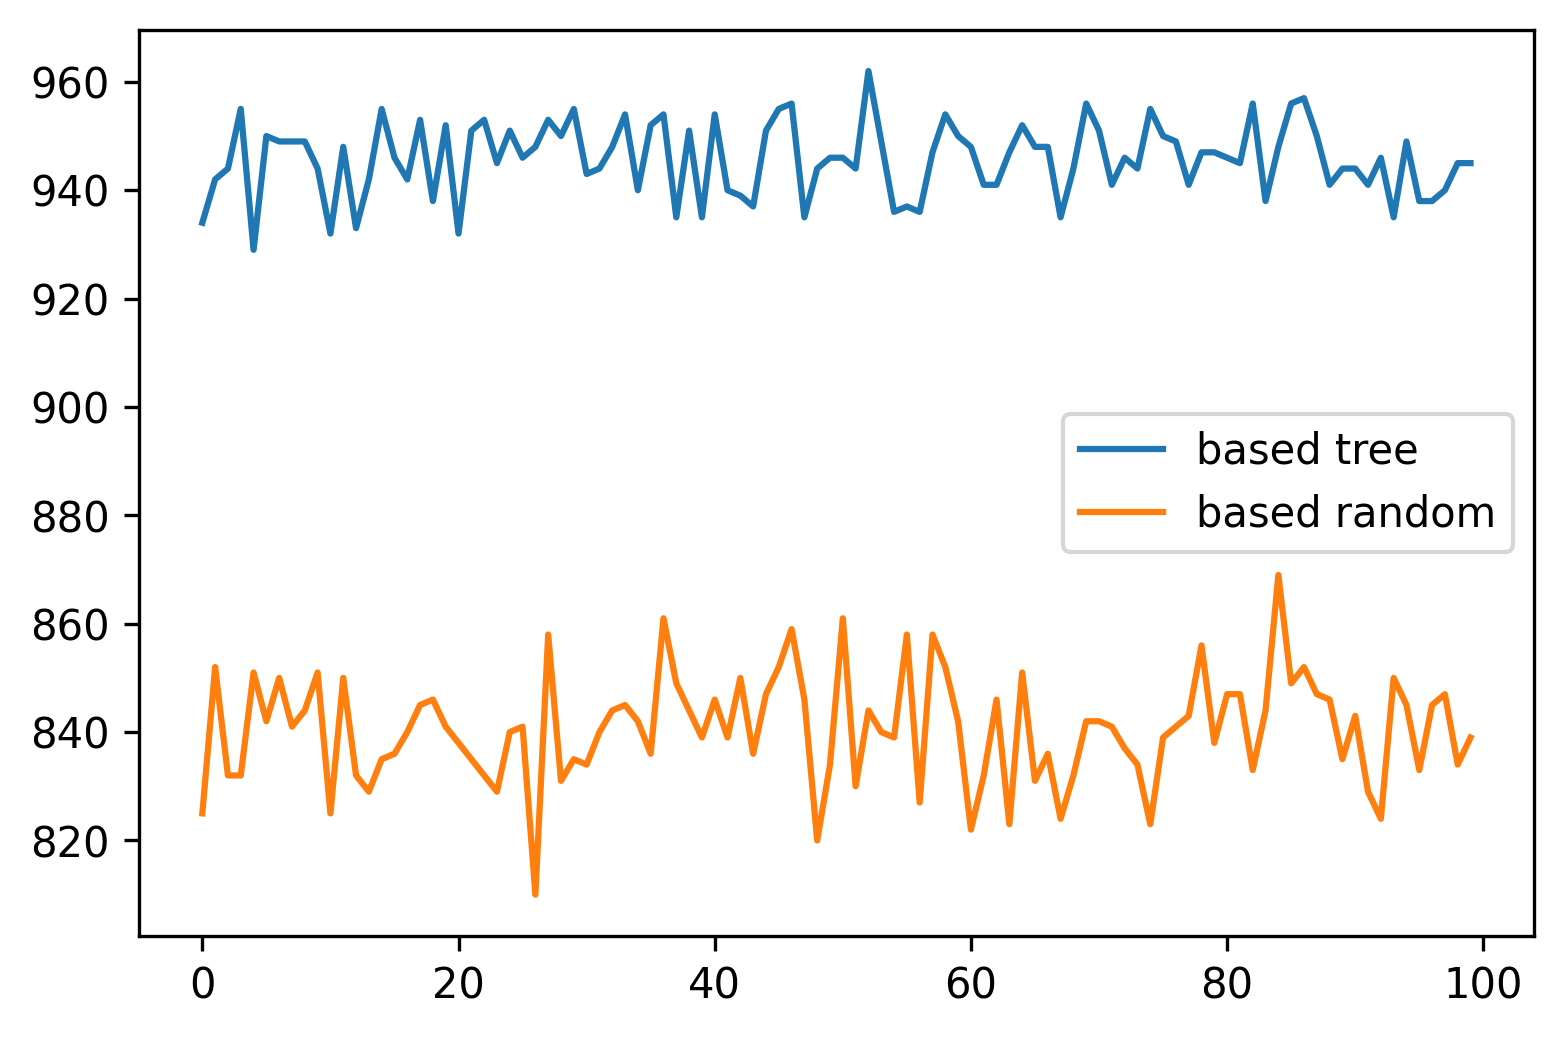

In [13]:
plt.figure(dpi=300)
plt.plot(counter_tree)
plt.plot(counter_random)
plt.legend(['based tree','based random'])